In [2]:
# from geopy.geocoders import Nominatim
# geocoder = Nominatim(user_agent="tid")
# stations = get_data.get_nearby_stations(
#     dog,
#     coordinates.geodetic2ecef((*geocoder.geocode("San Clemente Island, CA")[1], 0)),
#     dist=1.5e4
# )

# print("%d stations: " % len(stations))
# print(" ".join(stations))

In [ ]:
from collections import defaultdict
from datetime import datetime
import itertools
from laika import AstroDog, rinex_file
from laika.lib import coordinates
import math
from matplotlib import animation
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy

plt.rcParams["animation.html"] = "html5"
plt.rcParams["animation.embed_limit"] =  2**128
import argparse
from datetime import datetime, timedelta
from laika import AstroDog
from laika.lib import coordinates
import logging

from pytid.utils.configuration import Configuration
from pytid.gnss import bias_solve, connections, get_data, plot




In [1]:
conf = Configuration()

dog = AstroDog(cache_dir=conf.gnss.get("cache_dir"))

logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(filename)s:%(lineno)d][%(levelname)s] %(message)s",
    datefmt=conf.logging.get("datefmt")
)


stations = [
    "srs1", "cru1", "vndp", "p513", "ozst", "copr",
    "ana1", "cat3", "sni1", "scip", "p172", "islk",
    "p563", "p591", "azu1", "vdcy", "p231", "p300",
    "p467", "cat2", "sio5", "trak", "p588", "casn",
    "csst", "bar1", "p475", "tost", "ores", "p472",
    "p473", "p066", "p480", "p483", "p066", "p500",
    "p003", "scip"
]



# spacex launch in CA: June 12, 2019, 14:17 UTC
start_date = datetime.strptime("2019-06-12", "%Y-%m-%d")


duration = timedelta(days=1)
# make a "scenario"
scenario = get_data.ScenarioInfo(dog, start_date, duration, stations)

# turn our station data into "connections" which are periods of
# signal lock without cycle slips
logger.info("Reorganizing data into connections")
conns = connections.get_connections(scenario)
# then organize it so it's easier to look up
conn_map = connections.make_conn_map(conns)


# attempt to solve integer ambiguities
logger.info("Solving ambiguities")
#connections.correct_conns(station_locs, station_data, station_clock_biases, conns)
connections.correct_conns_code(scenario, conns)

# this will get vtec data, accounting for ambiguities but NOT clock biases
logger.info("Calculating vTEC data")
station_vtecs = get_data.get_vtec_data(scenario, conn_map=conn_map)

# this attempts to find coincidences of satellites and station observations
# from which to derive biases
logger.info("Locating coincidences for biases")
cal_dat = bias_solve.gather_data(start_date, station_vtecs)

# this uses least squares to attempt to resolve said ambiguities
# XXX: you want quite a few datapoints for this to work well
logger.info("Resolving biases")
sat_biases, rcvr_biases, tecs = bias_solve.lsq_solve(dog, *cal_dat)

# now go back and update our vtecs data...
logger.info("Correcting vTEC data with biases")
corrected_vtecs = get_data.correct_vtec_data(scenario, station_vtecs, sat_biases, rcvr_biases)
logger.info("Done")


2020-07-31 16:31:09 [<ipython-input-1-c8574342318a>:44][INFO] Reorganizing data into connections


srs1
cru1
vndp
p513
ozst
copr
ana1
cat3
sni1
scip
p172
islk
p563
p591
azu1
vdcy
p231
p300
p467
cat2
sio5
trak
p588
casn
csst
bar1
p475
tost
ores
p472
p473
p066
p480
p483
p066
p500
p003
scip
cycle slip: srs1-G21@142 mw jump of -299792.51
cycle slip: cru1-G21@142 mw jump of -3897302.06
cycle slip: vndp-R24@557 delay jump of -0.69
cycle slip: vndp-R24@568 delay jump of 0.71
cycle slip: vndp-R24@876 delay jump of 0.47
cycle slip: p513-G21@142 mw jump of -97.46
cycle slip: p513-R24@1637 delay jump of 0.74
cycle slip: p513-R24@1814 delay jump of -0.74
cycle slip: p513-R24@1815 delay jump of 0.72
cycle slip: ozst-G06@2083 delay jump of 1.48
cycle slip: ozst-G21@142 mw jump of -63.80
cycle slip: ozst-G29@341 delay jump of -2.18
cycle slip: ozst-G29@342 delay jump of 2.19
cycle slip: ozst-G29@343 delay jump of -2.14
cycle slip: ozst-G29@348 mw jump of -23.25
cycle slip: ozst-G29@351 mw jump of 12.42
cycle slip: ozst-G29@360 mw jump of -13.28
cycle slip: ozst-R03@1584 delay jump of -3.13
cycle s

cycle slip: csst-G02@2225 mw jump of 73848.92
cycle slip: csst-G17@1819 mw jump of 32289.71
cycle slip: csst-G27@743 mw jump of -599585.38
cycle slip: bar1-G21@142 mw jump of 5995849.25
cycle slip: p475-G21@142 mw jump of -88.81
cycle slip: p475-R24@942 delay jump of 0.49
cycle slip: tost-G06@2607 mw jump of 2098546.96
cycle slip: tost-G13@243 mw jump of 899377.06
cycle slip: tost-G26@1389 mw jump of -113332.64
cycle slip: tost-G26@1390 mw jump of -20502.81
cycle slip: ores-G01@1931 mw jump of 20693.95
cycle slip: ores-G11@1040 mw jump of -99100.78
cycle slip: ores-G15@2206 mw jump of -899376.42
cycle slip: ores-G21@142 mw jump of -599585.43
cycle slip: p473-G21@142 mw jump of 899377.43
cycle slip: p066-R24@1719 delay jump of 0.47
cycle slip: p066-R24@1755 delay jump of 0.48
cycle slip: p480-R24@1745 mw jump of -16.81
cycle slip: p483-R13@1515 delay jump of -0.50
cycle slip: p483-R19@1927 mw jump of 17.68
cycle slip: p483-R24@591 delay jump of 0.73
cycle slip: p483-R24@871 delay jump o

2020-07-31 16:35:03 [<ipython-input-1-c8574342318a>:51][INFO] Solving ambiguities


2020-07-31 16:35:07 [<ipython-input-1-c8574342318a>:56][INFO] Calculating vTEC data


srs1leted 2500/2511
cru1
vndp
p513
ozst
copr
ana1
cat3
sni1
scip
p172
islk
p563
p591
azu1
vdcy
p231
p300
p467
cat2
sio5
trak
p588
casn
csst
bar1
p475
tost
ores
p472
p473
p066
p480
p483
p066
p500
p003


2020-07-31 16:35:58 [<ipython-input-1-c8574342318a>:61][INFO] Locating coincidences for biases


scip
gathering data for   0/34


/Users/jparish/Work/missile-tid/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/jparish/Work/missile-tid/pytid/gnss/bias_solve.py:182: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  locs_lla = ecef2geodetic(numpy.stack(numpy.array(locs)[idxs]))


gathering data for   1/34
gathering data for   2/34
gathering data for   3/34
gathering data for   4/34
gathering data for   5/34
gathering data for   6/34
gathering data for   7/34
gathering data for   8/34
gathering data for   9/34
gathering data for  10/34
gathering data for  11/34
gathering data for  12/34
gathering data for  13/34
gathering data for  14/34
gathering data for  15/34
gathering data for  16/34
gathering data for  17/34
gathering data for  18/34
gathering data for  19/34
gathering data for  20/34
gathering data for  21/34
gathering data for  22/34
gathering data for  23/34
gathering data for  24/34
gathering data for  25/34
gathering data for  26/34
gathering data for  27/34
gathering data for  28/34
gathering data for  29/34
gathering data for  30/34
gathering data for  31/34
gathering data for  32/34
gathering data for  33/34


2020-07-31 16:36:07 [<ipython-input-1-c8574342318a>:66][INFO] Resolving biases


constructing matrix
solving


2020-07-31 16:36:13 [<ipython-input-1-c8574342318a>:70][INFO] Correcting vTEC data with biases
2020-07-31 16:36:24 [<ipython-input-1-c8574342318a>:72][INFO] Done


In [4]:
print("filtering")
filtered = dict()
for station in stations:
    filtered[station] = dict()
    for prn in get_data.satellites:
        if prn not in corrected_vtecs[station]:
            continue
        filtered[station][prn] = get_data.filter_contiguous(
            [(x if x else math.nan) for x in corrected_vtecs[station][prn][1]],
            short_min=2,
            long_min=12
        )
print("filtering done")

filtering
filtering done


In [80]:
from scipy.cluster.vq import kmeans2
import geopy.distance
def detect(i):
        
    lons = []
    lats = []
    vals = []
    measure = []
    max_tec = 0.1
    min_tec = -0.1
    
    for station in stations:
        for prn in get_data.satellites:
            if prn not in corrected_vtecs[station] or i >= len(corrected_vtecs[station][prn][0]):
                continue
            try:
                ecef = corrected_vtecs[station][prn][0][i]
            except IndexError:
                print(station, prn, i)
                raise
            if ecef is None:
                continue
        
            val = max([0]+[max(filtered[station][prn][i - n],0)/ (max_tec - min_tec) for n in range(15) if i - n >0])
                
            if val > 0.5:
                lat, lon, _ = coordinates.ecef2geodetic(ecef)
                lon = lon if lon > 0 else lon + 360
                lons.append(lon)
                lats.append(lat)
                vals.append(val)
                measure.append("%s:%s"%(station,prn))
            #vals.append(filtered[station][prn][i])
    
    total = len(vals)
    
    # if we have more than 15 satelites with .5 
    if total > 15:
        # find center of largest cluster using KMeans
        centeroids, _ = kmeans2(numpy.column_stack((lats,lons)), 1, iter = 5)
        (clat,clon) = centeroids.tolist()[0] 
        
        # find number of satellites with high TEC within 80km of center
        mask = numpy.array([geopy.distance.distance((ilat,ilon),(clat,clon)).km < 80 for (ilat,ilon,ival) in zip(lats, lons, vals) ])
        inDist = numpy.count_nonzero(mask)
        # If 6 satellites within 80km of centeroid, likely launch
        if inDist > 6:
            filt_lat = numpy.array(lats)[mask].tolist()
            filt_lon = numpy.array(lons)[mask].tolist()
            dists = [geopy.distance.distance((ilat,ilon),(clat,clon)).km for (ilat,ilon) in zip(filt_lat, filt_lon)]
            # return tick #, number within 80km and avg dist of all satellites with high TEC
            return (i, inDist, sum(dists)/len(dists))
        else: 
            return (0,0,0)
    else:
        return (0,0,0)


from multiprocessing import Pool
from itertools import groupby, cycle 
  
def group_sequence(l): 
    temp_list = cycle(l) 
  
    next(temp_list) 
    groups = groupby(l, key = lambda j: j + 1 == next(temp_list)) 
    for k, v in groups: 
        if k: 
            yield tuple(v) + (next((next(groups)[1])), ) 
            
p = Pool(24)
candidates = []
for (i,d,a) in p.imap(detect, range(2880)):
    if i != 0:
        print("potential launch at frame: %s (tick: %d, %d sats, avg dst: %f)" % (str(timedelta(seconds=i * 30) + start_date),i, d, a))
        candidates.append(i)

frames = list(itertools.chain.from_iterable([list(range(min(x) - 60 ,max(x) + 40)) for x in group_sequence(candidates)]))

potential launch at frame: 2019-06-12 14:26:30 (tick: 1733, 7 sats, avg dst: 43.583325)
potential launch at frame: 2019-06-12 14:27:00 (tick: 1734, 7 sats, avg dst: 43.412649)
potential launch at frame: 2019-06-12 14:27:30 (tick: 1735, 7 sats, avg dst: 43.357298)
potential launch at frame: 2019-06-12 14:28:00 (tick: 1736, 8 sats, avg dst: 47.873975)
potential launch at frame: 2019-06-12 14:28:30 (tick: 1737, 8 sats, avg dst: 47.863300)
potential launch at frame: 2019-06-12 14:29:00 (tick: 1738, 7 sats, avg dst: 68.445536)
potential launch at frame: 2019-06-12 14:29:30 (tick: 1739, 7 sats, avg dst: 68.715875)
potential launch at frame: 2019-06-12 14:30:00 (tick: 1740, 7 sats, avg dst: 69.041276)


In [99]:
numpy.full(3, 150) + [True, False, False]

array([151, 150, 150])

2020-07-31 22:28:16 [animation.py:1094][INFO] Animation.save using <class 'matplotlib.animation.PillowWriter'>


<Figure size 432x288 with 0 Axes>

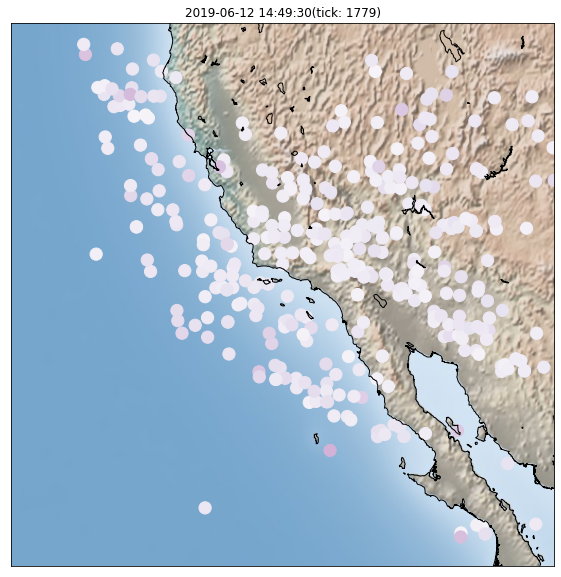

In [103]:
plt.clf()
plt.figure(figsize=(10,10))

globe = Basemap(projection='lcc',width=1900000, height=1900000,
              resolution='h', lat_0=33.575092, lon_0=-119.503783)
globe.drawcoastlines()
globe.shadedrelief()

scatter = globe.scatter([], [], marker='o')


def animate(i):
    plt.title( str(timedelta(seconds=i * 30) + start_date) + ("(tick: %d)" % i) )
    
    lons = []
    lats = []
    vals = []
    highlights = []
    max_tec = 0.1
    min_tec = -0.1
    
    for station in stations:
        for prn in get_data.satellites:
            if prn not in corrected_vtecs[station] or i >= len(corrected_vtecs[station][prn][0]):
                continue
            try:
                ecef = corrected_vtecs[station][prn][0][i]
            except IndexError:
                print(station, prn, i)
                raise
            if ecef is None:
                continue
        
            # Look back 60 * 30s (30 minutes) and use max TEC during that time 
            val = max([0]+[max(filtered[station][prn][i - n],0)/ (max_tec - min_tec) for n in range(15) if i - n >0])
                
            lat, lon, _ = coordinates.ecef2geodetic(ecef)
            lon = lon if lon > 0 else lon + 360
            lons.append(lon)
            lats.append(lat)
            vals.append(val)
            highlights.append(val > 0.5)
    plt.title( str(timedelta(seconds=i * 30) + start_date) + ("(tick: %d)" % i), fontdict={'color':'black'} )    
    hMask = numpy.array(highlights)
    sizes = numpy.full(len(vals), 150)
    
    # if we have more than 15 satelites with .5 
    # find center of largest cluster using KMeans
    if numpy.count_nonzero(hMask) > 15:
        filt_lats = numpy.array(lats)[hMask]
        filt_lons = numpy.array(lons)[hMask]
        centeroids, _ = kmeans2(numpy.column_stack((filt_lats,filt_lons)), 1, iter = 5)
        (clat,clon) = centeroids.tolist()[0] 
        # find number of satellites with high TEC within 80km of center
        inDist = numpy.count_nonzero([geopy.distance.distance((ilat,ilon),(clat,clon)).km < 80 for (ilat,ilon) in zip(filt_lats, filt_lons) ])
        if (inDist > 6):
            sizes = sizes +  (numpy.full(len(vals), 300) * hMask)
            plt.title( "[!] Possible Launch @ " + str(timedelta(seconds=i * 30) + start_date) + ("(tick: %d) [!]" % i), fontdict={'color':'red'})
        
    scatter.set_offsets(numpy.array(globe(lons, lats)).T)
    scatter.set_sizes(sizes)
    scatter.set_color( cm.PuRd(vals) )

def init():
    scatter.set_offsets([])
from tqdm.notebook import trange, tqdm
ani = animation.FuncAnimation(plt.gcf(), animate, init_func=init, frames=tqdm(frames), repeat=True, interval=100)

# ff_writer=animation.FFMpegWriter(extra_args=['-vcodec', 'libx264'])
p_writer = animation.PillowWriter(fps=15) 
ani.save("out.gif", writer=p_writer)